<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr2/blob/main/Borisov%20Vasily/Profpatolog_(Borisov).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи
Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.
Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности.


# Импорт библиотек и файлов с данными
- Импортируем основные библиотеки
- Загружаем список колонок датасета, которые мы предполагаем использовать для построния модели.
- Список колонок хранится в файле эксель. Файл эксель - на Яндекс Диске.
- Загружаем Датасет с Яндекс Клауда.
<br>data500 - первый (маленький) датасет, data600 - второй (большой) датасет

In [ ]:
import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split
import requests
from urllib.parse import urlencode
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, concatenate, Input, CategoryEncoding, Normalization, Activation, Conv1D
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import tensorflow as tf


# читаем список нужных нам полей с ЯД (файл эксель)
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/i/QWJez3NW1JGGcg'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
df_polei = pd.read_excel(download_url)

gdown.download('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/датасет%20профпатолог%20часть.xlsx', None, quiet=True)
data500 = pd.read_excel('E:\ProfPat\датасет%20профпатолог%20часть.xlsx')
data600 = pd.read_csv('E:\ProfPat\Весь период.csv', sep = ';', on_bad_lines='skip', engine='python' )


# Загрузка полей датасета
Первоначально список полей, которые использовались в модели, мы брали из датасета df_polei.
После получения второго (большого) датасета, я обнаружил, что в нем не хватает полей, которые я использовал для обучения модели. Поэтому было принято решение использовать для обучения пересечение полей датасетов data500 и data600.
<br>Уменьшение количества полей отразилось на обучении: модель, обученная на меньшем количестве полей, показала худшие результаты.

In [ ]:
listOfpolei= list(set(data600.columns.to_list()) & set(data500.columns.to_list()) )


# Обработка датасета
Обработку дааста начинаем с того, что оставляем в датасете только поля, которые имеются одновременно в первом и втором датасете

In [ ]:

data500 = data500[listOfpolei]
data600 = data600[listOfpolei]

- Приводим 6 возможных значений категории годности к 3 (в соответствии с ТЗ).
- Например если в датасете категория годности = "ГоденСКоррекциейЗрения", то мы заменяем это значение на "ОграниченноГоден"

In [ ]:
nmp=df_polei['POLE'].tolist()

def cleanDF(dt):
    dt=dt.replace('ГоденСКоррекциейЗрения','ОграниченноГоден')
    dt=dt.replace('ГоденСКоррекциейСлуха','ОграниченноГоден')
    dt=dt.replace('ГоденБезРаботНаВысотах','ОграниченноГоден')
    dt=dt.replace('НуждаетсяВДообследованииИЛечении','ВременноНегоден')
    dt=dt.replace('Негоден','ВременноНегоден')


    for idx, row in dt.iterrows():
        if not type(row.ВредныеФакторы) is str:
            dt.drop(axis = 0, index = idx ,inplace = True)
    dt = dt.astype({'ВредныеФакторы': str})

    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('янв','1')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('фев','2')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('мар','3')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('апр','4')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('май','5')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('июн','6')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('июл','7')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('авг','8')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('сен','9')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('окт','10')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('ноя','11')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('дек','12')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('04.02.2005','4.2.5')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('04.02.2004','4.2.4')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('04.02.2003','4.2.3')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('04.02.2002','4.2.2')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('04.02.2001','4.2.1')
    dt['ВредныеФакторы'] = dt['ВредныеФакторы'].str.replace('.0','.')
    for (columnName, columnData) in dt.items():
        if (str(columnName) in nmp)==False:
            dt.pop(columnName)

    dt = dt[dt.ЗаключениеМК.isin(['Годен', 'ВременноНегоден', 'ОграниченноГоден']) == True ]
    return dt

data600=cleanDF(data600)
data500=cleanDF(data500)

"Размножаем" минорные классы (классы с метками "ВременноНегоден" и "ОграниченноГоден")

In [ ]:
for i in range(5):
    data500 = pd.concat([data500,data500.loc[data500['ЗаключениеМК']. isin(['ВременноНегоден', 'ОграниченноГоден'])]])


# Токенизация датасета
Формируем списки:
- ListOfColumnNames - наименования колонок
- ListOfColumnValues - значения колонок
<!-- - ListOfColumnNames_Lists - значения колонки, в которой содержится список значений (пока это одна колонка - ВредныеФакторы) -->
- В дальнейшем мы будем использовать эту информацию для токенизации данных нашего датасета

In [ ]:
data500600 = pd.concat([data500, data600])

razdelitel = ","
columnsWithLists = ['ВредныеФакторы']
ListOfColumnNames = []
ListOfColumnValues = []
for (columnName, columnData) in data500600.items():
  ListOfColumnNames.append(columnName)
  if columnName in columnsWithLists:
    ListOfColumnValues.append(list(set(razdelitel.join(data500600[columnName].tolist()).splitlines()[0].split(','))))
  else:
    ListOfColumnValues.append(list(data500600[columnName].dropna().unique().flatten()))

Приводим наш датасет к векторам

In [ ]:
def get_vector(row, columnNumber):
  i = 0
  vector = []
  vectorLen = len(ListOfColumnValues[columnNumber])
  if vectorLen < 25:
    while i < vectorLen:
      if (ListOfColumnValues[columnNumber][i] == row[columnNumber]):
        Null_or_One = 1
      else:
        Null_or_One = 0
      vector = np.hstack([vector, Null_or_One])
      i+=1
  return vector


def get_vector_from_list(row, columnNumber):
  i = 0
  vector = []
  vectorLen = len(ListOfColumnValues[columnNumber])
  rowToList = ((row[columnNumber].split(',')))
  while i < vectorLen:
    if (ListOfColumnValues[columnNumber][i] in rowToList):
      Null_or_One = 1
    else:
      Null_or_One = 0
    vector = np.hstack([vector, Null_or_One])
    i+=1
  return vector


def extract_row_data(row):
  x1_data = []
  x2_data = []
  y_data = []
  for columnName in ListOfColumnNames:
    columnNumber = ListOfColumnNames.index(columnName)
    if columnName == 'ЗаключениеМК':
      y_data = np.hstack([y_data, get_vector(row, columnNumber)])
    elif columnName in columnsWithLists:
      x2_data = np.hstack([x2_data, get_vector_from_list(row, columnNumber)])
    else:
      x1_data = np.hstack([x1_data, get_vector(row, columnNumber)])
  return x1_data, x2_data, y_data



def construct_train_data(row_list):
    x1_data = []
    x2_data = []
    y_data = []
    for row in row_list:
      x1, x2, y = extract_row_data(row)
      x1_data.append(x1)
      x2_data.append(x2)
      y_data.append(y)
    return np.array(x1_data), np.array(x2_data), np.array(y_data)


x1_data500, x2_data500, y_data500 = construct_train_data(data500.values)
x1_data600, x2_data600, y_data600 = construct_train_data(data600.values)

В x3_data500 мы храним токены профессии сотрудника. Практика показала, что использование bag of words в нашем случае дает не очень хорошие результаты: в выборке есть опечатки и "экзотические" професии. <br> Чтобы обойти эту проблему использовали для токенизации FastText.<br>
Импортируем модель FastText. Модель большая (> 7 Гб), поэтому делал все локально. Конечно можно было придумать другой способ,чтобы человек, запускающий модель в колабе мог повторить мои шаги. Например использовать pickle или еще что-н., но меня мой подход устроил. И не думаю, что кому-то потреюуется запускать мою модель в colab.

In [ ]:
import fasttext
ft = fasttext.load_model('E:\cc.ru.300.bin')

Преобразуем профессию сотрудника в вектор, используя fasttext

In [ ]:
x3_data500 = []
for row in data500.values:
  wordVector = ft.get_word_vector(str(row[9]))
  x3_data500.append(wordVector)
x3_data500 = np.array(x3_data500)

In [ ]:
x3_data600 = []
for row in data600.values:
  wordVector = ft.get_word_vector(str(row[9]))
  x3_data600.append(wordVector)
x3_data600 = np.array(x3_data600)

# Обучение модели
Устанавливаем чекпоинты

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_chekpoint = ModelCheckpoint("MyModel_weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                                SaveBestOnly = True,
                                monitor = 'val_accuracy',
                                mode = 'max',
                                verbose = 1)

Описываем модель. Используем три входа, на каждый из которых подаем соответствующие массивы x1, x2, x3.

In [ ]:
%matplotlib inline
from tensorflow.keras import regularizers as regularizers

x1_test, x1_val, x2_test, x2_val, x3_test, x3_val, y_test, y_val = train_test_split(
                                                  x1_data600,
                                                  x2_data600,
                                                  x3_data600,
                                                  y_data600,
                                                  test_size=0.5,
                                                  shuffle=True,
                                                  random_state = 6)


input1 = Input((x1_data500.shape[1],))
input2 = Input((x2_data500.shape[1],))
input3 = Input((x3_data500.shape[1],))

x1 = input1                               # Ветка 1
x1 = Normalization()(x1)
x1 = Dense(256, activation="relu")(x1)
x1 = Dropout(0.1)(x1)                   #ddfds удал
x1 = Activation('relu')(x1)
x1 = Dense(32, activation="relu")(x1)
x1 = Activation('relu')(x1)
x1 = Dense(3, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(20, activation="relu")(x2)
# x2 = Dropout(0.15)(x2)
x2 = Dense(500, activation="relu")(x2)

x3 = input3                               # Ветка 3
x3 = Dense(50, activation="relu")(x3)
x3 = Dense(500, activation="relu")(x3)

x23 = concatenate([x2, x3])             # Объединение 3 веток
x23 = Dense(15, activation='relu')(x23) # Промежуточный слой



x = concatenate([x1, x23])              # Объединение 3 веток
x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
x = Dense(3, activation='softmax')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_final = Model((input1, input2, input3), x)

model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history = model_final.fit([x1_data500, x2_data500, x3_data500],
                           y_data500,
                           batch_size=256,
                           epochs=150,
                           validation_split=0.15,
                           callbacks = [model_chekpoint],
                           verbose=1)

Epoch 1/150
20/20 [==============================] - 18s 190ms/step - loss: 0.9214 - accuracy: 0.6502 - val_loss: 0.4872 - val_accuracy: 0.9198
Epoch 2/150
20/20 [==============================] - 2s 112ms/step - loss: 0.7454 - accuracy: 0.6530 - val_loss: 0.4882 - val_accuracy: 0.9198
Epoch 3/150
20/20 [==============================] - 2s 108ms/step - loss: 0.6826 - accuracy: 0.6530 - val_loss: 0.4110 - val_accuracy: 0.9198
Epoch 4/150
20/20 [==============================] - 2s 110ms/step - loss: 0.6087 - accuracy: 0.6546 - val_loss: 0.3997 - val_accuracy: 0.9267
Epoch 5/150
20/20 [==============================] - 2s 106ms/step - loss: 0.5577 - accuracy: 0.7056 - val_loss: 0.3119 - val_accuracy: 0.9920
Epoch 6/150
20/20 [==============================] - 2s 114ms/step - loss: 0.5030 - accuracy: 0.7539 - val_loss: 0.3352 - val_accuracy: 0.9851
Epoch 7/150
20/20 [==============================] - 2s 107ms/step - loss: 0.4377 - accuracy: 0.8362 - val_loss: 0.2242 - val_accuracy: 0.969

Визуальное представление модели

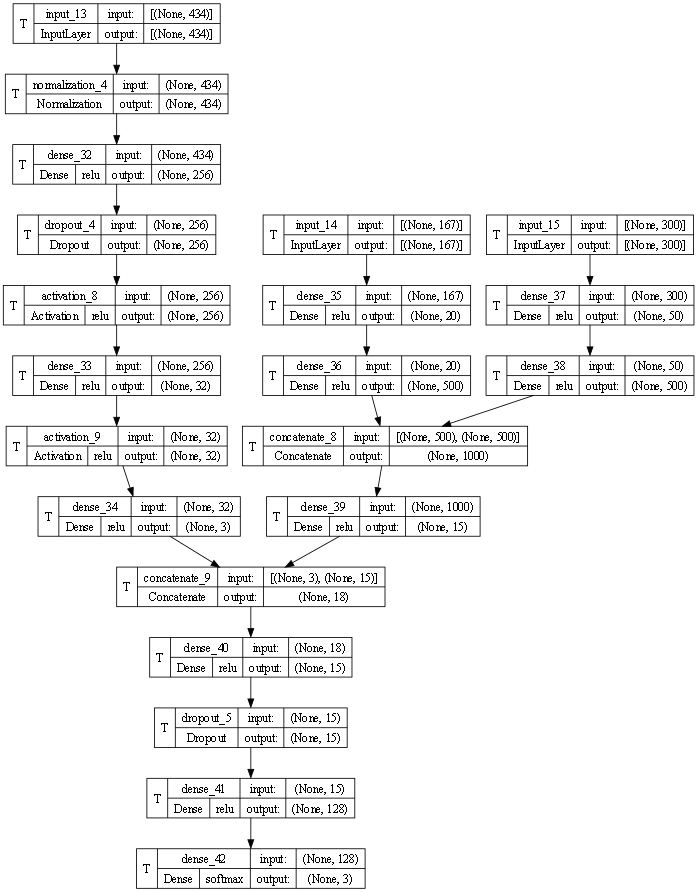

In [ ]:
utils.plot_model(model_final, show_shapes=True, show_layer_names=True, dpi=60, show_layer_activations=True, show_trainable=True)

Рисуем графики ошибки и верных ответов

289/289 [==============================] - 5s 15ms/step - loss: 1.2902 - accuracy: 0.9096


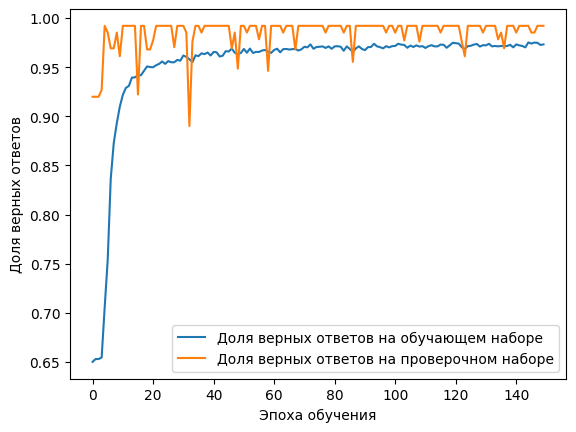

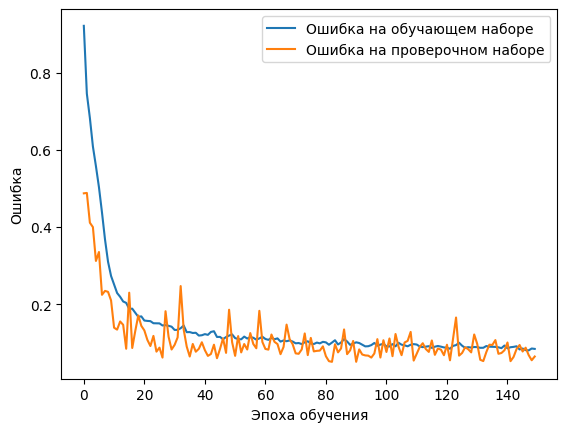

In [ ]:
from tensorflow.keras.models import load_model
# model_final = load_model('MyModel_weights.19-0.14.hdf5')
scores = model_final.evaluate([x1_test, x2_test, x3_test],
                        y_test,
                        verbose=1
                        )
scores2 = model_final.evaluate([x1_val, x2_val, x3_val],
                        y_val,
                        verbose=1
                        )
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()


plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')

plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

plt.legend()

plt.show()

Строим confusion matrix

289/289 [==============================] - 5s 15ms/step


array([[8225,  379,   29],
       [ 448,  122,   14],
       [  24,    0,    1]], dtype=int64)

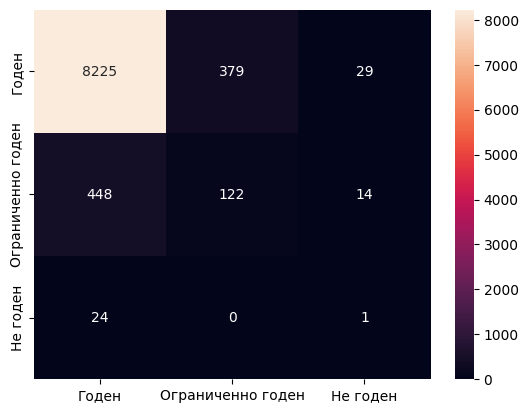

In [ ]:
y_pred = model_final.predict([x1_test, x2_test, x3_test])

y_pred2=np.argmax(y_pred, axis=1)
y_test2=np.argmax(y_test, axis=1)
cm_data = confusion_matrix(y_test2, y_pred2)


sns.heatmap(cm_data,
            annot=True,
            fmt='g',
            xticklabels=['Годен', 'Ограниченно годен', 'Не годен'],
            yticklabels=['Годен', 'Ограниченно годен', 'Не годен'])

cm_data